In [1]:
# Base packages
import dill
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
from wordcloud import WordCloud
import os,re, nltk, spacy

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Sklearn
from sklearn.externals import joblib
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import TfidfVectorizer

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt

# Path
folders = './final/'
file_url = folders + 'lematize_corpus_vec.csv'

model_folders = './models/'
dest_model_file_a = model_folders + 'lda_tfidf_bi_a.pkl'
dest_model_file_b = model_folders + 'lda_tfidf_bi_b.jlb'
dest_model_file_c = model_folders + 'lda_tfidf_bi_c_dill.pkl'

gs_model_bk = './gs_models/tfidf_bi.model'
dest_df = './dataframe/tfidf_bi.csv'
dest_vec = './vectorizer/tfidf_bi.vector'

# Init
nlp = spacy.load("en_core_web_sm",disable=['parser', 'ner'])
GRAMMAGE = (1, 2)
%matplotlib inline

# Custom
%run -i ./python-code/helper.py
%run -i ./python-code/config.py
%run -i ./python-code/nlp_scripts.py

C:\Users\Shaynie\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [ ]:
# https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

In [2]:
frame = pd.read_csv(file_url, sep='|', encoding="utf-8")
frame.head()

,text,list_text,lemma_text
0,People with an irregular heart beat condition...,"['people', 'with', 'an', 'irregular', 'heart',...",peopl irregular heart beat condit should be cl...
1,Politicians in the Catholic Republic of Irelan...,"['politicians', 'in', 'the', 'catholic', 'repu...",politician cathol republ ireland have overwhel...
2,In the winter months temperatures and humidity...,"['in', 'the', 'winter', 'months', 'temperature...",winter month temperatur humid level plummet as...
3,A system of special measures designed to impro...,"['system', 'of', 'special', 'measures', 'desig...",system special measur design improv fail hospi...
4,A can be hard enough to get on your own Add in...,"['can', 'be', 'hard', 'enough', 'to', 'get', '...",can be hard enough get own add challeng sleep ...


In [3]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25737 entries, 0 to 25736
Data columns (total 3 columns):
text          25737 non-null object
list_text     25737 non-null object
lemma_text    25729 non-null object
dtypes: object(3)
memory usage: 603.3+ KB


In [4]:
frame = frame[pd.notnull(frame['lemma_text'])]
frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25729 entries, 0 to 25736
Data columns (total 3 columns):
text          25729 non-null object
list_text     25729 non-null object
lemma_text    25729 non-null object
dtypes: object(3)
memory usage: 804.0+ KB


In [5]:
corpus = frame['lemma_text'].values

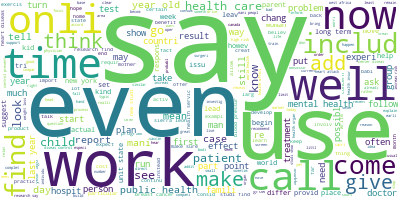

In [7]:
# Join the different processed title together.
long_string = ','.join(corpus)

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [8]:
# Split corpus into TRAIN, TEST, HOLDON
data_train = corpus[:TRAIN_SIZE]
TRAIN_SIZE = TRAIN_SIZE +1
TEST_SIZE = TEST_SIZE + TRAIN_SIZE
data_test = corpus[TRAIN_SIZE:TEST_SIZE]
TEST_SIZE = TEST_SIZE + 1
data_holdon = corpus[TEST_SIZE:]

In [6]:
# Create the Document-Word matrix
vectorizer = TfidfVectorizer(ngram_range = GRAMMAGE,
                             analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words=M_STOP_WORDS,   # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(corpus)

In [7]:
# 8. Check the Sparsicity
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.2115042565338064 %


In [8]:
# Build LDA Model
lda_model = LDA(n_topics=E_TOPICS,       # Number of topics
              max_iter=10,               # Max learning iterations
              learning_method='online',   
              random_state=100,          # Random state
              batch_size=128,            # n docs in each learning iter
              evaluate_every = -1,       # compute perplexity every n iters, default: Don't
              n_jobs = -1,               # Use all available CPUs
             )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

C:\Users\Shaynie\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=6, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


In [9]:
# 10
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -3434020.1232351973
Perplexity:  71411.94954703913
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'n_topics': 6,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [10]:
## GridSearchCV
# Define Search Param
search_params = {'n_components': N_COMPONENTS, 'learning_decay': LEARNING_DECAY}

# Init the Model
lda = LDA()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params,n_jobs=-1)

# Do the Grid Search
model.fit(data_vectorized)

C:\Users\Shaynie\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_components': [6, 10, 15, 20, 25, 30, 50], 'learning_decay': ['.3', '.5', '.7', '.9']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [11]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': '.3', 'n_components': 6}
Best Log Likelihood Score:  -1235823.3786910127
Model Perplexity:  77739.72863060725


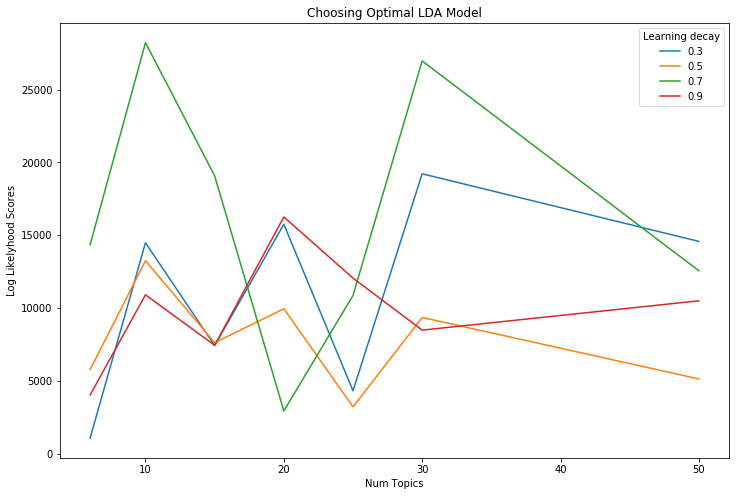

In [12]:
# Get Log Likelyhoods from Grid Search Output
n_topics = search_params['n_components']
learning_decay = LEARNING_DECAY
one_third = len(n_topics)
two_third = one_third*2
three_fourth = one_third*3

gscore = dict(model.cv_results_)
log_likelyhoods_3 = gscore['std_train_score'][0:one_third]
log_likelyhoods_5 = gscore['std_train_score'][one_third:two_third]
log_likelyhoods_7 = gscore['std_train_score'][two_third:three_fourth]
log_likelyhoods_9 = gscore['std_train_score'][three_fourth:]


# log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.5]
# log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.7]
# log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_3, label='0.3')
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()


### 1. Saving Models 

In [13]:
# Have: best_lda_model


## ----------------------------------------------------------
## ----------------------------------------------------------
## Pickle
## ----------------------------------------------------------
pickle.dump(best_lda_model,open(dest_model_file_a,'wb'))

## Joblib
## ----------------------------------------------------------
joblib.dump(best_lda_model, dest_model_file_b)

## Dill
## ----------------------------------------------------------
dill.dump(best_lda_model, open(dest_model_file_c,'wb'))

## Vectorizer
## ----------------------------------------------------------
dill.dump(vectorizer, open(dest_vec,'wb'))


## ----------------------------------------------------------
## ----------------------------------------------------------
## Backup GridSearchCV models
## ----------------------------------------------------------
dill.dump(model, open(gs_model_bk,'wb'))

## Best topic
## ----------------------------------------------------------
BEST_TOPICS = model.best_params_['n_components']

In [17]:
# best_lda_model = dill.load(open(dest_model_file_c,'rb'))

In [37]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(model.best_params_['n_components'])]

# index names
docnames = ["Doc" + str(i) for i in range(len(corpus))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

KeyboardInterrupt: 

In [17]:
df_document_topic.to_csv(dest_df, sep='|')

In [33]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,5,19611
1,0,2689
2,4,2115
3,2,686
4,1,437
5,3,191


In [36]:
df_topic_distribution['Num Documents'].value_counts()

191      1
686      1
437      1
2115     1
19611    1
2689     1
Name: Num Documents, dtype: int64

In [19]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

C:\Users\Shaynie\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
5     -276.288269  197.308411       1        1  67.087621
0      131.149918 -379.338318       2        1  12.254104
4      140.454437  326.632050       3        1  11.013511
2      392.254425  -29.725962       4        1   3.992089
1       21.090010  -24.843813       5        1   3.502943
3     -282.061798 -239.029648       6        1   2.149733, topic_info=       Category        Freq           Term       Total  loglift  logprob
term                                                                    
114856  Default  163.000000          virus  163.000000  30.0000  30.0000
40530   Default  206.000000           food  206.000000  29.0000  29.0000
113731  Default  165.000000         vaccin  165.000000  28.0000  28.0000
52860   Default  166.000000         infect  166.000000  27.0000  27.0000
32573   Default  151.000000            eat  151.000000  26.0000  26.0000
74723   Default  111.000000       outbreak  111.000000  25.0000  25.0000
14414   Default  199.000000           case  199.000000  24.0000  24.0000
117158  Default  138.000000         weight  138.000000  23.0000  23.0000
12818   Default  102.000000         calori  102.000000  22.0000  22.0000
49137   Default  295.000000         hospit  295.000000  21.0000  21.0000
38307   Default  103.000000            fat  103.000000  20.0000  20.0000
36014   Default  124.000000        exercis  124.000000  19.0000  19.0000
70798   Default  158.000000            nhs  158.000000  18.0000  18.0000
28406   Default   92.000000           diet   92.000000  17.0000  17.0000
46213   Default  488.000000         health  488.000000  16.0000  16.0000
104332  Default   84.000000          sugar   84.000000  15.0000  15.0000
40148   Default   84.000000            flu   84.000000  14.0000  14.0000
72963   Default  110.000000         offici  110.000000  13.0000  13.0000
29480   Default  250.000000         diseas  250.000000  12.0000  12.0000
17656   Default   74.000000       cigarett   74.000000  11.0000  11.0000
118658  Default  108.000000         worker  108.000000  10.0000  10.0000
2653    Default   71.000000         africa   71.000000   9.0000   9.0000
117413  Default   73.000000           west   73.000000   8.0000   8.0000
59547   Default   62.000000        liberia   62.000000   7.0000   7.0000
100826  Default   83.000000         spread   83.000000   6.0000   6.0000
31429   Default  125.000000          drink  125.000000   5.0000   5.0000
46908   Default  116.000000        healthi  116.000000   4.0000   4.0000
23083   Default  140.000000        countri  140.000000   3.0000   3.0000
76430   Default  452.000000        patient  452.000000   2.0000   2.0000
10741   Default  154.000000           bodi  154.000000   1.0000   1.0000
...         ...         ...            ...         ...      ...      ...
88539    Topic6    0.629884   record onlin    1.385109   3.0518  -9.2578
77464    Topic6    1.311458         payrol    3.321493   2.9106  -8.5245
69863    Topic6    0.589924     need parti    1.337380   3.0214  -9.3234
96793    Topic6    1.209415  sever depress    3.846077   2.6829  -8.6055
116042   Topic6    1.081169           wart    3.346803   2.7099  -8.7176
50084    Topic6    3.767310            hpv   20.721253   2.1350  -7.4693
70958    Topic6    0.782524       nhs mean    2.204522   2.8041  -9.0409
85795    Topic6    0.814208   public debat    2.370417   2.7712  -9.0012
17790    Topic6    1.815273      circumcis   13.210139   1.8551  -8.1994
15855    Topic6    1.532226  cervic cancer   11.460980   1.8276  -8.3689
114053   Topic6    1.049126       vanguard    5.039457   2.2705  -8.7477
15854    Topic6    1.548104         cervic   13.653049   1.6629  -8.3586
70798    Topic6    3.535029            nhs  158.801523   0.0349  -7.5329
97055    Topic6    0.669941    share decis    2.205222   2.6484  -9.1962
58586    Topic6    1.362501     leadership   18.259698   1.244

In [20]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords

,aaa,aafter,aall,aalmost,aan,aand,aani,aanyth,aap,aap committe,...,zucchini lemon,zucchini onion,zucchini red,zucchini round,zucchini salt,zucchini veggi,zucker,zuckerman,zumba,zumba class
Topic0,0.166694,0.166669,0.166764,0.166668,0.166718,0.166690,0.166730,0.166669,0.167571,0.176266,...,0.166667,0.166667,0.166668,0.166667,0.166667,0.166667,0.166670,0.168105,0.166681,0.166668
Topic1,0.166670,0.166669,0.166669,0.166670,0.166670,0.166669,0.166670,0.166672,0.166726,0.166676,...,0.166667,0.166667,0.166670,0.166667,0.166668,0.166667,0.166671,0.166669,0.166680,0.166669
Topic2,0.166942,0.166670,0.166669,0.166670,0.166669,0.166669,0.166670,0.166807,0.166670,0.166676,...,0.723476,0.452313,0.470497,0.599365,0.671481,0.381356,0.166670,0.166669,0.166679,0.166669
Topic3,0.166671,0.166670,0.166670,0.166671,0.166670,0.166670,0.166671,0.166673,0.166674,0.166678,...,0.166667,0.166667,0.166670,0.166667,0.166668,0.166667,0.166672,0.166725,0.166683,0.166669
Topic4,0.168139,0.168094,0.167392,0.167003,0.168464,0.168128,0.169585,0.212529,0.167567,0.215460,...,0.166667,0.166989,0.169269,0.167322,0.166805,0.167236,0.170475,0.166668,2.701074,1.348502
Topic5,1.174769,1.122435,2.136026,0.655908,2.003861,4.060734,0.835504,0.581571,3.160961,0.581302,...,0.166667,0.166667,0.168262,0.166667,0.166667,0.166667,1.006155,1.699534,0.204796,0.168142


In [21]:
# Show top n keywords for each topic
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=18)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17
Topic 0,virus,vaccin,outbreak,infect,health,case,flu,nhs,hospit,liberia,africa,west,sierra,spread,leon,offici,sierra leon,diseas
Topic 1,nhs,allergan,social care,care,valeant,servic,staff,ashya,cup stimul,organis,social,tidbit,patient,sovaldi,burnham,local,support,health social
Topic 2,pepper,recip,oil,fat,oliv,dish,chees,oliv oil,tomato,salt,fresh,garlic,egg,protein,low fat,flavor,onion,sauc
Topic 3,hpv,nhs,hpv vaccin,vaccin,circumcis,cervic,cervic cancer,leadership,payrol,sever depress,wart,vanguard,staff,gardasil,ccgs,sector,moder depress,manag
Topic 4,food,eat,calori,weight,fat,diet,sugar,exercis,cigarett,fruit,bodi,drink,healthi,workout,pound,veget,meal,day
Topic 5,peopl,patient,health,studi,year,research,child,cancer,drug,care,woman,new,time,medic,make,doctor,hospit,risk


In [22]:
unseem_data = '''
Ultra-processed foods - such as chicken nuggets, ice cream and breakfast cereals - have been linked to early death and poor health, scientists say. 
Researchers in France and Spain say the amount of such food being eaten has soared.
Their studies are not definite proof of harm but do come hot on the heels of trials suggesting ultra-processed foods 
.
Experts expressed caution but called for further investigation. 
The term comes from a way of classifying food by how much industrial processing it has been through.
The lowest category is "unprocessed or minimally processed foods", which include: • fruit • vegetables • milk • meat • legumes such as lentils • seeds • grains such as rice • eggs
"Processed foods" have been altered to make them last longer or taste better - generally using salt, oil, sugar or fermentation.
This category includes: • cheese • bacon • home-made bread • tinned fruit and vegetables • smoked fish • beer
Then come "ultra-processed foods", which have been through more substantial industrial processing and often have long ingredient lists on the packet, including added preservatives, sweeteners or colour enhancers. 
If a product contains more than five ingredients, it is probably ultra-processed, says Prof Maira Bes-Rastrollo, of the University of Navarra, citing a maxim.
Examples include: • processed meat such as sausages and hamburgers • breakfast cereals or cereal bars • instant soups • sugary fizzy drinks • chicken nuggets • cake • chocolate • ice cream • mass-produced bread • many "ready to heat" meals such as pies and pizza | meal-replacement shakes 
, by the University of Navarra, in Spain, followed 19,899 people for a decade and assessed their diet every other year. There were 335 deaths during the study.
But for every 10 deaths among those eating the least ultra-processed food, there were 16 deaths among those eating the most (more than four portions a day).
, by the University of Paris, followed 105,159 people for five years and assessed their diet twice a year.
It showed those eating more ultra-processed food had worse heart health. 
Rates of cardiovascular disease were 277 per 100,000 people per year among those eating the most ultra-processed food, compared with 242 per 100,000 among those eating the least. 
The rapid increase of ultra-processed foods over less processed foods, "may drive a substantial burden of cardiovascular diseases in the next decades," said Dr Mathilde Touvier, of the University of Paris.
"[The] evidence is accumulating," said Dr Touvier, noting "increasing numbers of independent studies". Prof Bes-Rastrollo said she was "very certain" ultra-processed foods were bad for health.
Last year, a link was made with 
.
The challenge is being 100% sure. The studies have spotted a pattern between highly processed food and poor health but they cannot prove that one causes the other. 
Those who ate the most ultra-processed food were also more likely to have other unhealthy behaviours, such as smoking, which the researchers tried to account for. 
But there's no guarantee everything relevant was covered, says Kevin McConway, a professor of statistics at The Open University.
"These studies do increase my confidence that there's something real behind these associations - but I'm still far from sure."
The first trial of ultra-processed foods showed they led people to eat more and put on weight. 
Researchers at the US National Institutes of Health monitored every morsel of food that volunteers ate for a month.
And when given ultra-processed food, they ate 500 calories a day more than when they were given unprocessed meals.
Other suggestions include: 
These ideas still need researching.
While the term ultra-processed food may be new, the health advice will be very familiar: adopt a Mediterranean-style diet.
Such a diet includes plenty of minimally or unprocessed foods, such as fruit, vegetables, fish, nuts and seeds, beans, lentils and wholegrains, said Victoria Taylor, senior dietician at the British Heart Foundation.
"This, along with exercising regularly and not smoking, has been shown to be beneficial for lowering risk of heart and circulatory disease."
Measures such as taxation and marketing restrictions on ultra-processed foods, should be considered, said Prof Bes-Rastrollo, given the weight of evidence. 
There are certainly a lot of critics. 
The labelling of food as ultra-processed could be inconsistent, said Dr Gunter Kuhnle, an expert in nutrition and health at the University of Reading
"It is also not obvious why salami is considered to be ultra-processed, yet cheese, which often requires considerably more processing steps and additives, is not.  The classification combines a wide range of foods with very different potential impacts on health, which limits its usefulness as a basis for recommendations."
The studies were published in the British Medical Journal.
'''

In [23]:
# Define function to predict topic for a given text document.

# Predict the topic
# for text in data_test:
#     topic, prob_scores = predict_topic(text = text)
#     print(topic)
topic, prob_scores = predict_topic(unseem_data)
print(topic)
pprint(prob_scores)

[[0.01326978 0.01297147 0.01299643 0.0130227  0.56513741 0.38260221]] 4
['food', 'eat', 'calori', 'weight', 'fat', 'diet', 'sugar', 'exercis', 'cigarett', 'fruit', 'bodi', 'drink', 'healthi', 'workout', 'pound', 'veget', 'meal', 'day']
array([[0.01326978, 0.01297147, 0.01299643, 0.0130227 , 0.56513741,
        0.38260221]])


### Fitting with KMeans

Component's weights: 
 [[ 0.08  0.03  0.02  0.02  0.08  0.99]
 [ 0.99  0.02  0.03  0.02  0.09 -0.09]]
Perc of Variance Explained: 
 [0.37 0.27]


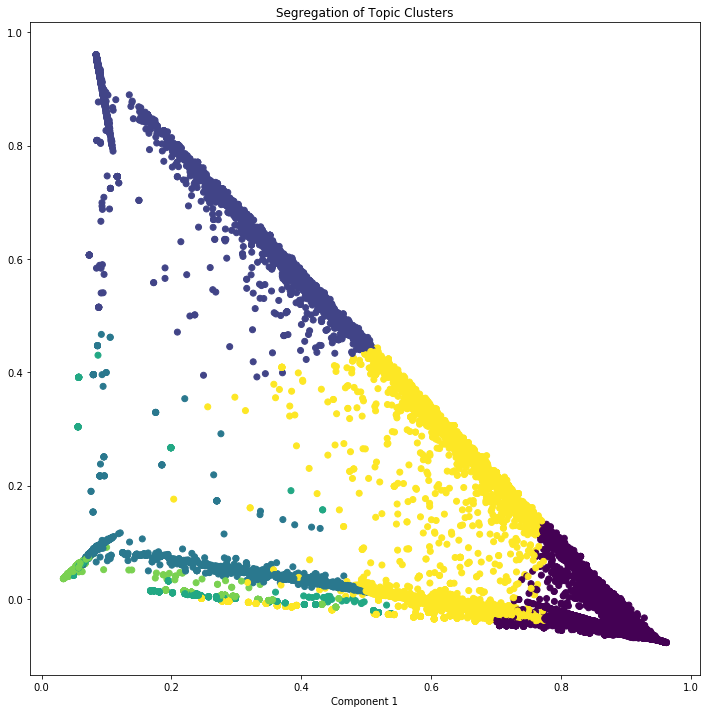

In [24]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=BEST_TOPICS, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

# Plotting clusters
plotting_clusters(x, y, clusters)

In [25]:
from sklearn.metrics.pairwise import euclidean_distances

def similar_documents(text, doc_topic_probs, documents = corpus, nlp=nlp, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [26]:
# Get similar documents
doc_ids, docs = similar_documents(text=unseem_data, doc_topic_probs=lda_output, documents = corpus, top_n=1, verbose=True)
print('\n', docs[0][:500])

[[0.01326978 0.01297147 0.01299643 0.0130227  0.56513741 0.38260221]] 4
Topic KeyWords:  ['food', 'eat', 'calori', 'weight', 'fat', 'diet', 'sugar', 'exercis', 'cigarett', 'fruit', 'bodi', 'drink', 'healthi', 'workout', 'pound', 'veget', 'meal', 'day']
Topic Prob Scores of text:  [[0.  0.  0.  0.  0.6 0.4]]
Most Similar Doc's Probs:   [[0.  0.  0.  0.  0.6 0.4]]

 normal experi mild panic first triathlon swim especi mass start ok take break breaststrok even hang offici kayak as long don use make forward progress catch breath minim chao start back side main pack swim confid increas run bike be entir differ beast straight run least start feel strang muscl adapt differ bodi posit differ demand begin slowli allow bodi adjust minut settl normal run rhythm also note triathlon run pace will almost alway be slow pace standard run race use bright color towel allow


### Fitting with DBSCAN

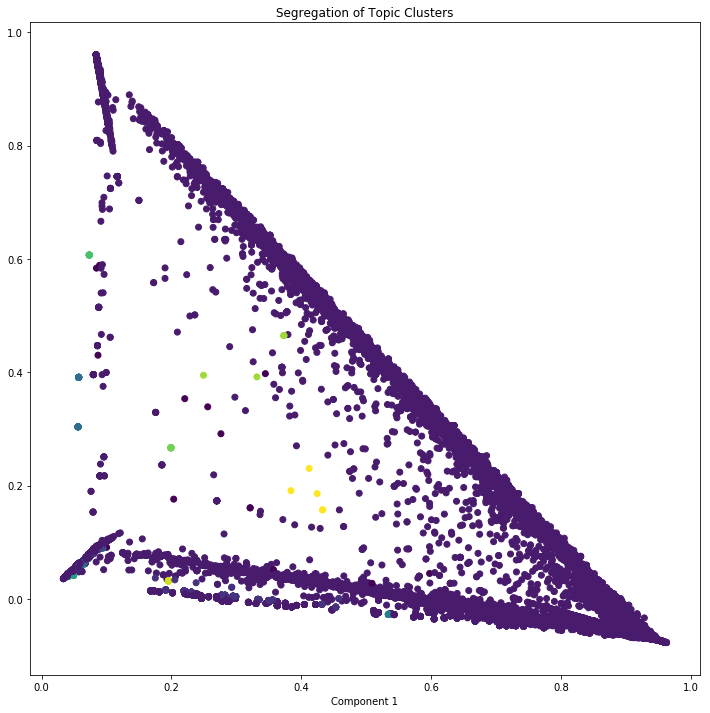

In [27]:
# Construct the DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# ss = StandardScaler()
# X = ss.fit_transform(lda_output)

dbscan_clusters = DBSCAN(eps=0.123, min_samples = 4).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Plotting clusters
plotting_clusters(x, y, dbscan_clusters)